# Level 1: Greedy Noise-Aware GHZ Path Finding

**Approach:** Modify the DFS path search to prioritize neighbors by their noise score
instead of connectivity degree.

**Key idea:** At each step, sort neighbors by:
$$\text{Score}(j) = F_{CZ}(i, j) \times F_{RO}(j)$$

where $F_{CZ}$ is the CZ gate fidelity and $F_{RO}$ is the readout fidelity.

**Multi-start:** Try starting from the top 10 qubits ranked by readout fidelity.

In [1]:
# CELL 1: Setup
import sys
import subprocess

major, minor = sys.version_info[:2]
if not (major == 3 and minor >= 11):
    print(f"❌ Python {major}.{minor} - need 3.11+")
    raise SystemExit
print(f"✅ Python {major}.{minor} OK")

pip_ver = subprocess.check_output(["pip", "--version"]).decode().split()[1]
if not pip_ver.startswith("25"):
    !pip install --upgrade pip==25.*
    print("✅ pip 25 installed. RESTART runtime!")
else:
    print("✅ pip OK")

✅ Python 3.12 OK
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
✅ pip 25 installed. RESTART runtime!


In [2]:
# %pip install -q -U "iqm-client" "qiskit" matplotlib networkx

# install iqm-client with qrisp extras
!pip install -U "iqm-client>=33.0.1" "qrisp[iqm]"
# used for visualization
!pip install matplotlib networkx

from qrisp.interface import IQMBackend

In [3]:
# ============================================
# CONFIGURATION - CHANGE THESE AS NEEDED
# ============================================
API_TOKEN = "Yxt82O2nQ6L2g4RSySBmkJetjVb35KEY+yGsUjsVMDwBnBcGPAh/8KW1ElCHu5OF"
DEVICE = "emerald"  # Changed from sirius to garnet to emerald!

quantum_computer = IQMBackend(
    api_token = API_TOKEN,
    device_instance = DEVICE
)

print(f"✅ Connected to IQM {DEVICE.upper()}!")

✅ Connected to IQM EMERALD!


In [4]:
# CELL 2: Imports
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, transpile
from iqm.qiskit_iqm import IQMProvider

print("Imports OK")

Imports OK


In [5]:
# CELL 3: Configuration & Connection

API_TOKEN = "Yxt82O2nQ6L2g4RSySBmkJetjVb35KEY+yGsUjsVMDwBnBcGPAh/8KW1ElCHu5OF"  # <-- Replace with your Resonance API token
DEVICE = "emerald"
N_QUBITS = 30
SHOTS = 10000

provider = IQMProvider(
    "https://resonance.meetiqm.com",
    quantum_computer=DEVICE,
    token=API_TOKEN,
)
backend = provider.get_backend()
print(f"Backend: {DEVICE}, Qubits: {backend.num_qubits}")

Backend: emerald, Qubits: 54


In [7]:
# CELL 4: Load Calibration Data from JSON
import json
import re

# Path to calibration file - update if needed
CALIBRATION_FILE = "./2026-01-31T18_28_46.713632Z.json"

def load_calibration(filepath):
    """Load calibration data from IQM quality-metric-set JSON file.

    Extracts:
    - READOUT_P10: P(measure 1 | true 0) = error_0_to_1
    - READOUT_P01: P(measure 0 | true 1) = error_1_to_0
    - CZ_FIDELITY: Two-qubit CZ gate fidelities
    """
    with open(filepath) as f:
        data = json.load(f)

    ro_p10 = {}  # error_0_to_1
    ro_p01 = {}  # error_1_to_0
    cz_fids = {}

    for obs in data['observations']:
        field = obs['dut_field']
        value = obs['value']

        # Readout error_0_to_1 (P(measure 1 | true 0))
        m = re.match(r'metrics\.ssro\.measure\.constant\.(QB\d+)\.error_0_to_1', field)
        if m:
            ro_p10[m.group(1)] = value
            continue

        # Readout error_1_to_0 (P(measure 0 | true 1))
        m = re.match(r'metrics\.ssro\.measure\.constant\.(QB\d+)\.error_1_to_0', field)
        if m:
            ro_p01[m.group(1)] = value
            continue

        # CZ gate fidelity
        m = re.match(r'metrics\.rb\.clifford\.uz_cz\.(QB\d+)__(QB\d+)\.fidelity', field)
        if m:
            key = f'{m.group(1)}__{m.group(2)}'
            cz_fids[key] = value

    return ro_p10, ro_p01, cz_fids

READOUT_P10, READOUT_P01, CZ_FIDELITY = load_calibration(CALIBRATION_FILE)

print(f"Loaded calibration from: {CALIBRATION_FILE}")
print(f"  Readout P10 (error_0_to_1): {len(READOUT_P10)} qubits")
print(f"  Readout P01 (error_1_to_0): {len(READOUT_P01)} qubits")
print(f"  CZ fidelities: {len(CZ_FIDELITY)} edges")

# Show worst qubits and gates
worst_ro = sorted(READOUT_P10.items(), key=lambda x: x[1], reverse=True)[:3]
print(f"\nWorst readout P10: {worst_ro}")
worst_cz = sorted(CZ_FIDELITY.items(), key=lambda x: x[1])[:3]
print(f"Worst CZ gates: {worst_cz}")

Loaded calibration from: ./2026-01-31T18_28_46.713632Z.json
  Readout P10 (error_0_to_1): 54 qubits
  Readout P01 (error_1_to_0): 54 qubits
  CZ fidelities: 82 edges

Worst readout P10: [('QB31', 0.0765), ('QB29', 0.042), ('QB7', 0.032)]
Worst CZ gates: [('QB44__QB50', 0.9086148007977384), ('QB21__QB29', 0.96145586061668), ('QB27__QB28', 0.9621512715504612)]


In [8]:
# CELL 5: Parse noise data into indexed dicts

# Readout fidelity per qubit (index-based)
ro_fids = {}
for qb in READOUT_P10:
    idx = int(qb[2:]) - 1
    ro_fids[idx] = 1.0 - (READOUT_P10[qb] + READOUT_P01[qb]) / 2.0

# CZ gate fidelity per edge (index-based, symmetric)
cz_fids = {}
for pair, fid in CZ_FIDELITY.items():
    parts = pair.split('__')
    idx1 = int(parts[0][2:]) - 1
    idx2 = int(parts[1][2:]) - 1
    cz_fids[(idx1, idx2)] = fid
    cz_fids[(idx2, idx1)] = fid

print(f"Parsed: {len(ro_fids)} readout fidelities, {len(cz_fids)} CZ fidelities")
print(f"Best RO:  QB{max(ro_fids, key=ro_fids.get)+1} = {max(ro_fids.values()):.4f}")
print(f"Worst RO: QB{min(ro_fids, key=ro_fids.get)+1} = {min(ro_fids.values()):.4f}")

Parsed: 54 readout fidelities, 164 CZ fidelities
Best RO:  QB18 = 0.9940
Worst RO: QB4 = 0.9147


In [9]:
# CELL 6: Helper functions

def build_topology_graph(backend):
    """Builds NetworkX graph from backend coupling map."""
    G = nx.Graph()
    for i in range(backend.num_qubits):
        G.add_node(i)
    for edge in backend.coupling_map:
        G.add_edge(edge[0], edge[1])
    return G


def create_ghz_circuit(n, basis='Z'):
    """Creates GHZ circuit in Z or X measurement basis."""
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    if basis == 'X':
        for i in range(n):
            qc.h(i)
    qc.measure_all()
    return qc


def compute_fidelity(counts_z, counts_x, n):
    """Computes GHZ fidelity witness from Z and X basis measurements."""
    total_z = sum(counts_z.values())
    p00 = counts_z.get('0' * n, 0) / total_z
    p11 = counts_z.get('1' * n, 0) / total_z
    zz = 2 * (p00 + p11) - 1

    total_x = sum(counts_x.values())
    xx = sum(
        (1 if s.count('1') % 2 == 0 else -1) * c / total_x
        for s, c in counts_x.items()
    )

    fidelity = 0.5 + 0.25 * (zz + xx)
    return {
        'p00': p00, 'p11': p11, 'zz': zz, 'xx': xx,
        'fidelity': fidelity,
        'witness': 0.5 - fidelity,
        'entangled': fidelity > 0.5,
    }


def mitigate_zz(counts, n, path_indices):
    """Mitigate ZZ expectation value using readout error model."""
    p10 = np.array([READOUT_P10[f'QB{idx+1}'] for idx in path_indices])
    p01 = np.array([READOUT_P01[f'QB{idx+1}'] for idx in path_indices])

    total = sum(counts.values())
    p_00_00 = np.prod(1 - p10)
    p_11_11 = np.prod(1 - p01)
    p_00_11 = np.prod(p01)
    p_11_00 = np.prod(p10)

    A = np.array([[p_00_00, p_00_11], [p_11_00, p_11_11]])
    p_meas = np.array([
        counts.get('0' * n, 0) / total,
        counts.get('1' * n, 0) / total,
    ])

    try:
        A_inv = np.linalg.inv(A)
        p_true = np.clip(A_inv @ p_meas, 0, 1)
        if p_true.sum() > 1:
            p_true /= p_true.sum()
        return 2 * (p_true[0] + p_true[1]) - 1, p_true[0], p_true[1]
    except np.linalg.LinAlgError:
        p00 = counts.get('0' * n, 0) / total
        p11 = counts.get('1' * n, 0) / total
        return 2 * (p00 + p11) - 1, p00, p11


def mitigate_xx(counts, n, path_indices):
    """Mitigate XX expectation value using readout error model."""
    p10 = np.array([READOUT_P10[f'QB{idx+1}'] for idx in path_indices])
    p01 = np.array([READOUT_P01[f'QB{idx+1}'] for idx in path_indices])

    total = sum(counts.values())
    p_flip = (p10 + p01) / 2
    parity_factor = np.prod(1 - 2 * p_flip)

    xx_raw = sum(
        (1 if s.count('1') % 2 == 0 else -1) * c / total
        for s, c in counts.items()
    )

    if abs(parity_factor) > 0.01:
        xx_mit = np.clip(xx_raw / parity_factor, -1, 1)
    else:
        xx_mit = xx_raw

    return xx_mit, xx_raw


print("Helper functions ready")

Helper functions ready


In [10]:
# CELL 7: Build topology graph

topology = build_topology_graph(backend)
print(f"Topology: {topology.number_of_nodes()} nodes, {topology.number_of_edges()} edges")

Topology: 54 nodes, 81 edges


In [11]:
# CELL 8: LEVEL 1 - Greedy Noise-Aware DFS
#
# Key change: instead of sorting neighbors by degree,
# sort by Score(j) = F_CZ(curr, j) * F_RO(j)
# Multi-start from top qubits by readout fidelity.

def greedy_noise_aware_path(G, n_qubits, ro_fids, cz_fids):
    """Greedy noise-aware DFS path finding.

    At each step, neighbors are sorted by:
        Score(j) = F_CZ(current, j) * F_RO(j)

    Multi-start from the top 10 qubits ranked by readout fidelity.
    """
    DEFAULT_CZ = 0.97  # assume for edges without calibration data

    def path_total_score(path):
        """Total path score = product of all CZ fidelities * all RO fidelities."""
        score = 1.0
        for node in path:
            score *= ro_fids.get(node, 0.95)
        for i in range(len(path) - 1):
            score *= cz_fids.get((path[i], path[i + 1]), DEFAULT_CZ)
        return score

    def dfs_path(start, n):
        stack = [(start, [start])]
        best_path = []
        best_score = -1

        while stack:
            curr, path = stack.pop()

            if len(path) == n:
                score = path_total_score(path)
                if score > best_score:
                    best_score = score
                    best_path = path.copy()
                continue

            if len(path) > len(best_path):
                best_path = path.copy()
                best_score = path_total_score(path)

            # GREEDY: sort neighbors by local noise score
            def local_score(neighbor):
                f_cz = cz_fids.get((curr, neighbor), DEFAULT_CZ)
                f_ro = ro_fids.get(neighbor, 0.95)
                return f_cz * f_ro

            neighbors = [
                nb for nb in G.neighbors(curr)
                if nb not in path
            ]
            neighbors.sort(key=local_score, reverse=True)

            # Explore top 5 to avoid combinatorial explosion
            for nb in neighbors[:5]:
                stack.append((nb, path + [nb]))

        return best_path, best_score

    # Multi-start from top 10 qubits by readout fidelity
    starts = sorted(G.nodes(), key=lambda n: ro_fids.get(n, 0), reverse=True)[:10]

    overall_best_path = []
    overall_best_score = -1

    print(f"Greedy noise-aware DFS for {n_qubits}-qubit path...")
    print(f"Starting from top 10 qubits by readout fidelity")

    for start in starts:
        path, score = dfs_path(start, n_qubits)
        if len(path) >= n_qubits and score > overall_best_score:
            overall_best_path = path[:n_qubits]
            overall_best_score = score
            print(f"  QB{start+1}: found {len(path)}-qubit path, score={score:.6f}")
        elif len(path) > len(overall_best_path):
            overall_best_path = path
            overall_best_score = score
            print(f"  QB{start+1}: partial {len(path)}-qubit path, score={score:.6f}")

    return overall_best_path


# Also keep the original DFS for comparison
def find_topology_path(G, n_qubits):
    """Original topology-only DFS (sorts by degree)."""
    def dfs_path(start, n):
        stack = [(start, [start])]
        best = []
        while stack:
            curr, path = stack.pop()
            if len(path) == n:
                return path
            if len(path) > len(best):
                best = path.copy()
            for neighbor in sorted(G.neighbors(curr),
                                   key=lambda x: G.degree(x), reverse=True):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
        return best

    nodes_by_degree = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
    for start in nodes_by_degree[:15]:
        path = dfs_path(start, n_qubits)
        if len(path) >= n_qubits:
            return path[:n_qubits]
    return path


# Find both paths
greedy_path = greedy_noise_aware_path(topology, N_QUBITS, ro_fids, cz_fids)
print()
topo_path = find_topology_path(topology, N_QUBITS)

greedy_names = [f'QB{i+1}' for i in greedy_path]
topo_names = [f'QB{i+1}' for i in topo_path]

print(f"\n{'='*60}")
print(f"PATH COMPARISON")
print(f"{'='*60}")
print(f"\nGreedy noise-aware: {greedy_names}")
print(f"Original topology:  {topo_names}")

# Compare path quality
def path_quality(path):
    cz_list = [cz_fids.get((path[i], path[i+1]), 0.97) for i in range(len(path)-1)]
    ro_list = [ro_fids.get(n, 0.95) for n in path]
    return {
        'avg_cz': np.mean(cz_list),
        'min_cz': np.min(cz_list),
        'avg_ro': np.mean(ro_list),
        'min_ro': np.min(ro_list),
        'total_score': np.prod(cz_list) * np.prod(ro_list),
    }

q_greedy = path_quality(greedy_path)
q_topo = path_quality(topo_path)

print(f"\n{'Metric':<20} | {'Greedy':>12} | {'Topology':>12}")
print(f"{'-'*50}")
for key in ['avg_cz', 'min_cz', 'avg_ro', 'min_ro', 'total_score']:
    print(f"{key:<20} | {q_greedy[key]:>12.6f} | {q_topo[key]:>12.6f}")

Greedy noise-aware DFS for 30-qubit path...
Starting from top 10 qubits by readout fidelity
  QB18: found 30-qubit path, score=0.411772
  QB6: found 30-qubit path, score=0.416702
  QB53: found 30-qubit path, score=0.423337


PATH COMPARISON

Greedy noise-aware: ['QB53', 'QB49', 'QB48', 'QB42', 'QB43', 'QB35', 'QB34', 'QB26', 'QB25', 'QB33', 'QB32', 'QB24', 'QB23', 'QB15', 'QB16', 'QB8', 'QB9', 'QB17', 'QB18', 'QB19', 'QB11', 'QB5', 'QB1', 'QB2', 'QB6', 'QB12', 'QB20', 'QB21', 'QB13', 'QB14']
Original topology:  ['QB5', 'QB1', 'QB2', 'QB6', 'QB12', 'QB13', 'QB14', 'QB22', 'QB30', 'QB31', 'QB39', 'QB38', 'QB37', 'QB29', 'QB28', 'QB36', 'QB44', 'QB50', 'QB54', 'QB53', 'QB52', 'QB48', 'QB47', 'QB41', 'QB42', 'QB43', 'QB35', 'QB34', 'QB33', 'QB32']

Metric               |       Greedy |     Topology
--------------------------------------------------
avg_cz               |     0.987729 |     0.982210
min_cz               |     0.977330 |     0.908615
avg_ro               |     0.983442 |    

In [12]:
# CELL 9: Create & Transpile Circuits

qc_z = create_ghz_circuit(N_QUBITS, 'Z')
qc_x = create_ghz_circuit(N_QUBITS, 'X')

# Greedy noise-aware routing
qc_greedy_z = transpile(qc_z, backend, initial_layout=greedy_path, optimization_level=3)
qc_greedy_x = transpile(qc_x, backend, initial_layout=greedy_path, optimization_level=3)

# Original topology routing
qc_topo_z = transpile(qc_z, backend, initial_layout=topo_path, optimization_level=3)
qc_topo_x = transpile(qc_x, backend, initial_layout=topo_path, optimization_level=3)

# Naive auto-routing
qc_naive_z = transpile(qc_z, backend, optimization_level=3)
qc_naive_x = transpile(qc_x, backend, optimization_level=3)

print(f"{'='*60}")
print(f"CIRCUIT COMPARISON ({N_QUBITS}-qubit GHZ)")
print(f"{'='*60}")
for label, qc in [('Greedy noise-aware', qc_greedy_z),
                   ('Topology DFS', qc_topo_z),
                   ('Naive auto-route', qc_naive_z)]:
    print(f"\n{label}:")
    print(f"   Depth: {qc.depth()}, Gates: {sum(qc.count_ops().values())}")

CIRCUIT COMPARISON (30-qubit GHZ)

Greedy noise-aware:
   Depth: 60, Gates: 119

Topology DFS:
   Depth: 60, Gates: 119

Naive auto-route:
   Depth: 60, Gates: 119


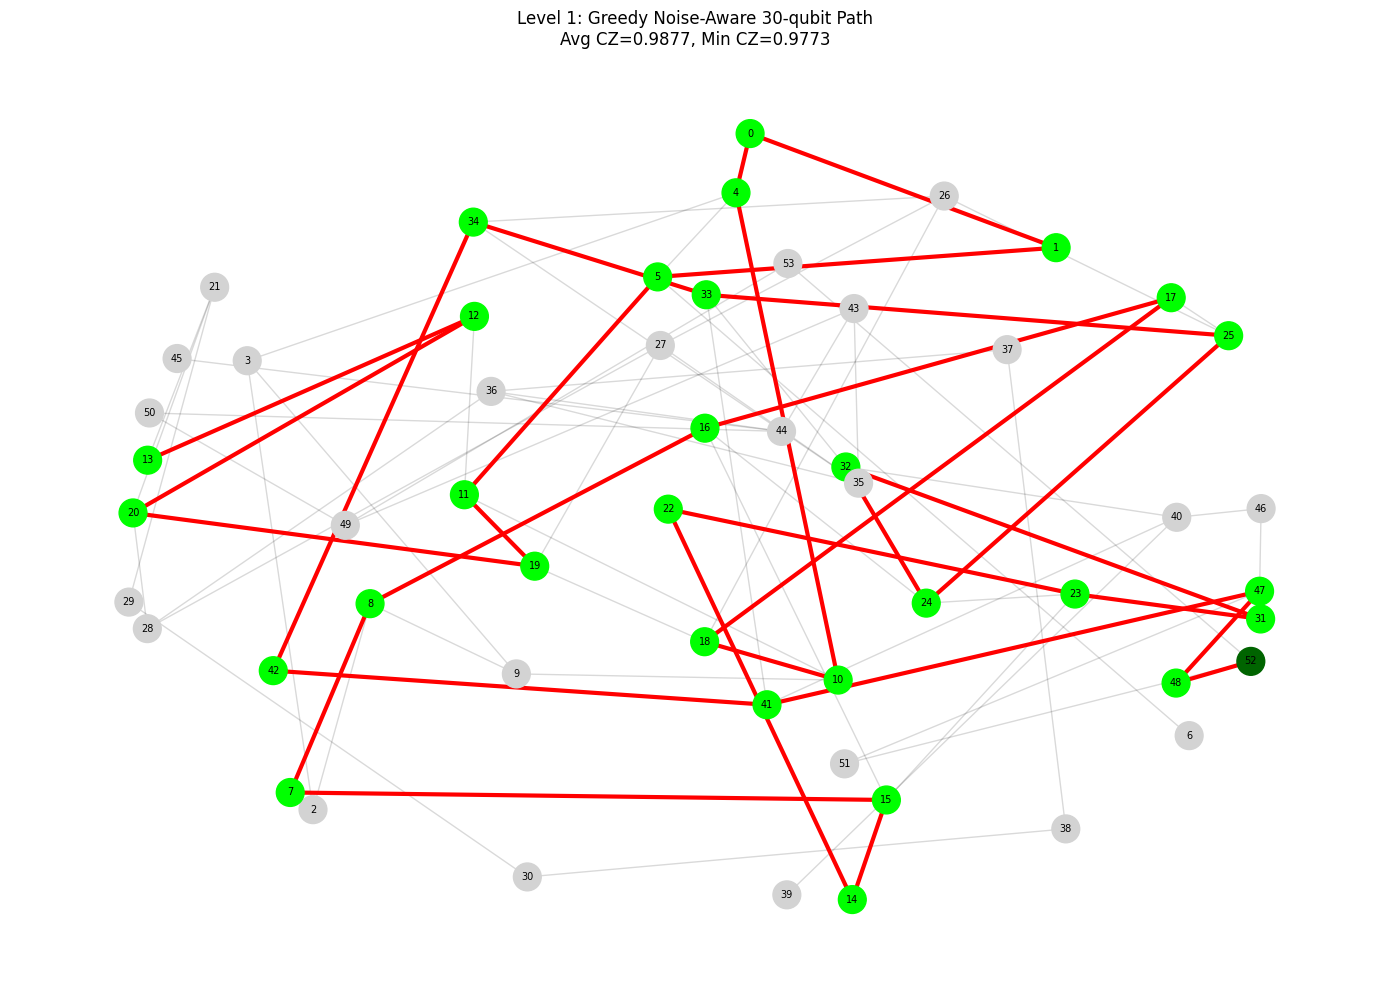

In [13]:
# CELL 10: Visualize Path

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(topology, seed=42, k=2, iterations=100)

nx.draw_networkx_edges(topology, pos, alpha=0.15)

colors = ['lightgray'] * topology.number_of_nodes()
for i, node in enumerate(greedy_path):
    colors[node] = 'lime' if i > 0 else 'darkgreen'

path_edges = [(greedy_path[i], greedy_path[i+1]) for i in range(len(greedy_path)-1)]
nx.draw_networkx_edges(topology, pos, edgelist=path_edges,
                       edge_color='red', width=3)
nx.draw_networkx_nodes(topology, pos, node_color=colors, node_size=400)
nx.draw_networkx_labels(topology, pos, font_size=7)

plt.title(f'Level 1: Greedy Noise-Aware {N_QUBITS}-qubit Path\n'
          f'Avg CZ={q_greedy["avg_cz"]:.4f}, Min CZ={q_greedy["min_cz"]:.4f}')
plt.axis('off')
plt.tight_layout()
plt.show()

---
## Experiments Below Cost Credits!
---

In [14]:
# CELL 11: Run Experiments

experiments = {
    'Greedy noise-aware': (qc_greedy_z, qc_greedy_x, greedy_path),
    'Topology DFS':       (qc_topo_z, qc_topo_x, topo_path),
    'Naive auto-route':   (qc_naive_z, qc_naive_x, None),
}

all_results = {}

for name, (qc_z_t, qc_x_t, path) in experiments.items():
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {name}")
    print(f"{'='*60}")

    print("  [1/2] Z-basis...")
    job_z = backend.run(qc_z_t, shots=SHOTS)
    print(f"         Job: {job_z.job_id()}")
    counts_z = job_z.result().get_counts()

    print("  [2/2] X-basis...")
    job_x = backend.run(qc_x_t, shots=SHOTS)
    print(f"         Job: {job_x.job_id()}")
    counts_x = job_x.result().get_counts()

    all_results[name] = {'counts_z': counts_z, 'counts_x': counts_x, 'path': path}

print(f"\nAll experiments done!")


EXPERIMENT: Greedy noise-aware
  [1/2] Z-basis...
         Job: 019c1889-fe40-7e22-802d-6e7dd6389858


Progress in queue:   0%|          | 0/8 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c188a-cdf7-7b61-a447-916f0e594be6


Progress in queue:   0%|          | 0/9 [00:00<?, ?it/s]


EXPERIMENT: Topology DFS
  [1/2] Z-basis...
         Job: 019c188b-8b8d-7592-a410-04d6fd63ef86


Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c188b-f8ad-73c1-a3af-5f005ff2a5bb


Progress in queue:   0%|          | 0/6 [00:00<?, ?it/s]


EXPERIMENT: Naive auto-route
  [1/2] Z-basis...
         Job: 019c188c-7d2d-7dc2-849f-069fc3e99fdd


Progress in queue:   0%|          | 0/6 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c188c-fd6d-70a1-a143-cac7629e54eb


Progress in queue:   0%|          | 0/7 [00:00<?, ?it/s]


All experiments done!


In [15]:
# CELL 12: Results

print(f"{'='*80}")
print(f"RESULTS: {N_QUBITS}-qubit GHZ, {SHOTS} shots")
print(f"{'='*80}")

fidelity_data = {}

for name, data in all_results.items():
    counts_z = data['counts_z']
    counts_x = data['counts_x']
    path = data['path']

    raw = compute_fidelity(counts_z, counts_x, N_QUBITS)

    # Mitigated (only if we know the path)
    if path is not None:
        zz_mit, p00_mit, p11_mit = mitigate_zz(counts_z, N_QUBITS, path)
        xx_mit, _ = mitigate_xx(counts_x, N_QUBITS, path)
        f_mit = 0.5 + 0.25 * (zz_mit + xx_mit)
    else:
        f_mit = raw['fidelity']  # no mitigation possible without path

    fidelity_data[name] = {'raw': raw['fidelity'], 'mitigated': f_mit, 'raw_data': raw}

    print(f"\n--- {name} ---")
    print(f"   P(00...0)  = {raw['p00']:.4f}")
    print(f"   P(11...1)  = {raw['p11']:.4f}")
    print(f"   <ZZ...Z>   = {raw['zz']:.4f}")
    print(f"   <XX...X>   = {raw['xx']:.4f}")
    print(f"   F(raw)     = {raw['fidelity']:.4f}  {'ENTANGLED' if raw['entangled'] else ''}")
    if path is not None:
        print(f"   F(mitigated)= {f_mit:.4f}  {'ENTANGLED' if f_mit > 0.5 else ''}")

print(f"\n{'='*80}")
print(f"COMPARISON")
print(f"{'='*80}")
print(f"{'Method':<25} | {'F(raw)':>10} | {'F(mitigated)':>12}")
print(f"{'-'*55}")
for name, fd in fidelity_data.items():
    print(f"{name:<25} | {fd['raw']:>10.4f} | {fd['mitigated']:>12.4f}")

RESULTS: 30-qubit GHZ, 10000 shots

--- Greedy noise-aware ---
   P(00...0)  = 0.1068
   P(11...1)  = 0.0180
   <ZZ...Z>   = -0.7504
   <XX...X>   = 0.1188
   F(raw)     = 0.3421  
   F(mitigated)= 0.4262  

--- Topology DFS ---
   P(00...0)  = 0.0705
   P(11...1)  = 0.0112
   <ZZ...Z>   = -0.8366
   <XX...X>   = 0.0528
   F(raw)     = 0.3040  
   F(mitigated)= 0.3855  

--- Naive auto-route ---
   P(00...0)  = 0.0601
   P(11...1)  = 0.0053
   <ZZ...Z>   = -0.8692
   <XX...X>   = 0.0584
   F(raw)     = 0.2973  

COMPARISON
Method                    |     F(raw) | F(mitigated)
-------------------------------------------------------
Greedy noise-aware        |     0.3421 |       0.4262
Topology DFS              |     0.3040 |       0.3855
Naive auto-route          |     0.2973 |       0.2973


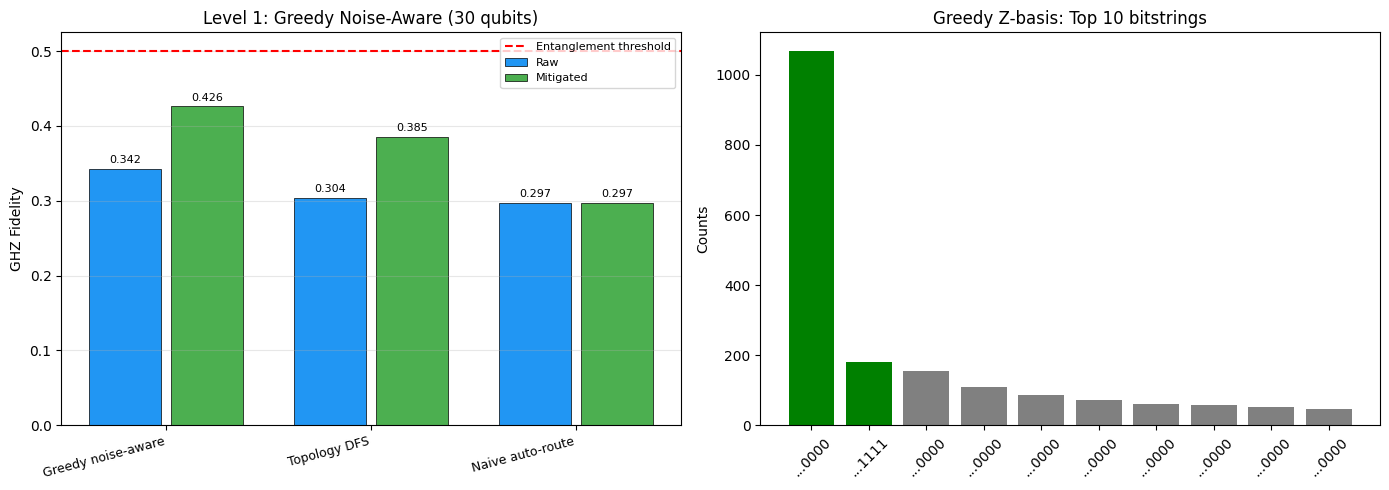

In [16]:
# CELL 13: Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax = axes[0]
names = list(fidelity_data.keys())
raw_vals = [fidelity_data[n]['raw'] for n in names]
mit_vals = [fidelity_data[n]['mitigated'] for n in names]
x = np.arange(len(names))

ax.bar(x - 0.2, raw_vals, 0.35, label='Raw', color='#2196F3', edgecolor='black', linewidth=0.5)
ax.bar(x + 0.2, mit_vals, 0.35, label='Mitigated', color='#4CAF50', edgecolor='black', linewidth=0.5)
ax.axhline(y=0.5, color='red', linestyle='--', label='Entanglement threshold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=15, ha='right', fontsize=9)
ax.set_ylabel('GHZ Fidelity')
ax.set_title(f'Level 1: Greedy Noise-Aware ({N_QUBITS} qubits)')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

for i, (r, m) in enumerate(zip(raw_vals, mit_vals)):
    ax.text(i - 0.2, r + 0.005, f'{r:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + 0.2, m + 0.005, f'{m:.3f}', ha='center', va='bottom', fontsize=8)

# Histogram of top states for greedy Z-basis
ax2 = axes[1]
counts_z = all_results['Greedy noise-aware']['counts_z']
sorted_c = sorted(counts_z.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f'...{s[-4:]}' for s, _ in sorted_c]
values = [c for _, c in sorted_c]
bar_colors = ['green' if s in ['0'*N_QUBITS, '1'*N_QUBITS] else 'gray' for s, _ in sorted_c]
ax2.bar(range(len(labels)), values, color=bar_colors)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45)
ax2.set_ylabel('Counts')
ax2.set_title('Greedy Z-basis: Top 10 bitstrings')

plt.tight_layout()
plt.show()

## Summary: Level 1 - Greedy Noise-Aware Search

### Method
Modified the DFS path-finding to sort neighbors by:
$$\text{Score}(j) = F_{CZ}(\text{current}, j) \times F_{RO}(j)$$

instead of connectivity degree. Multi-start from top 10 qubits by readout fidelity.

### GHZ Fidelity Witness
$$F_{GHZ} = \frac{1}{2} + \frac{1}{4}(\langle ZZ\cdots Z \rangle + \langle XX\cdots X \rangle)$$

If $F > 0.5$: entanglement proven.

### Pros
- Simple modification to existing code
- Directly considers gate and readout quality at each step

### Cons
- **Locally greedy**: may miss globally better paths
- A locally good next step may lead to a dead-end or low-quality tail
- Does not consider the quality of the *entire* path holistically